In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, minmax_scale, OrdinalEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch
import joblib 


In [2]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


## In this project we want to see what type of diabetic patients readmit for less than 30 days

In [4]:
df = pd.read_csv('./Data/diabetic_data.csv')
df.tail()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,NO
101765,443867222,175429310,Caucasian,Male,[70-80),?,1,1,7,6,...,No,No,No,No,No,No,No,No,No,NO


In [6]:
print(f'\nThe are {df.columns.shape[0]} features.')
print(f'\n {df.select_dtypes(include=['int64','float64','number']).shape[1]} numerical features.')
print(f'\n {df.select_dtypes(include=['object','category']).count().shape[0]} categorical features.\n')
df.info()


The are 50 features.

 13 numerical features.

 37 categorical features.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-nu

In [7]:
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [9]:
df.isnull().sum()

encounter_id                    0
patient_nbr                     0
race                            0
gender                          0
age                             0
weight                          0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                      0
medical_specialty               0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                          0
diag_2                          0
diag_3                          0
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

In [11]:

# Drop two columns as most of the values in these two columns are NaN
df.drop(['A1Cresult', 'max_glu_serum'], axis=1, inplace=True)

# Check the missing values again
df.isnull().sum()

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
payer_code                  0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose  

----------

## Feature Engineering

----------

In [17]:
# Figure out how to merge these columns in one or just drop them all
df['diag_1'].unique()
df['diag_2'].unique()
df['diag_3'].unique()


array(['?', '255', 'V27', '403', '250', 'V45', '38', '486', '996', '197',
       '250.6', '427', '627', '414', '416', '714', '428', '582', 'V43',
       '250.01', '263', '250.42', '276', '482', '401', '250.41', '585',
       '781', '278', '998', '568', '682', '618', '250.02', '305', '707',
       '496', '599', '715', '424', '518', '553', '794', '411', 'V42',
       '531', '511', '490', '562', '250.8', '250.7', '250.52', '784',
       '491', '581', '420', '8', '724', '730', '789', '131', '250.82',
       '999', '41', '493', '250.03', '753', '786', '529', 'E888', '425',
       '595', '303', '560', '711', '492', '332', '296', '438', '362',
       '250.4', '654', '244', 'V70', '737', '625', '681', '250.51', '404',
       'V10', '810', '280', '440', '785', '588', '569', '272', '997',
       '250.43', '918', '584', '54', '788', '426', '722', '250.92', '196',
       '461', '535', '787', '891', '284', '458', '648', '780', '182',
       '285', '593', '413', '664', '564', '201', '356', 'V15', '2

In [19]:
# As these are only the code I would drop all three columns
df.drop(['diag_2', 'diag_3','diag_1'], axis=1, inplace=True)


In [21]:
# To evaluate if we need to keep this feature or not
# It looks like there is mostly one value in this feature
df['acetohexamide'].value_counts()

acetohexamide
No        101765
Steady         1
Name: count, dtype: int64

In [23]:
df.drop(['acetohexamide'], axis=1, inplace=True)

## Features' distribusion

Here I wanted to see how is the distributions of each feature. I can decide either I need to remove the feature or are they useful.

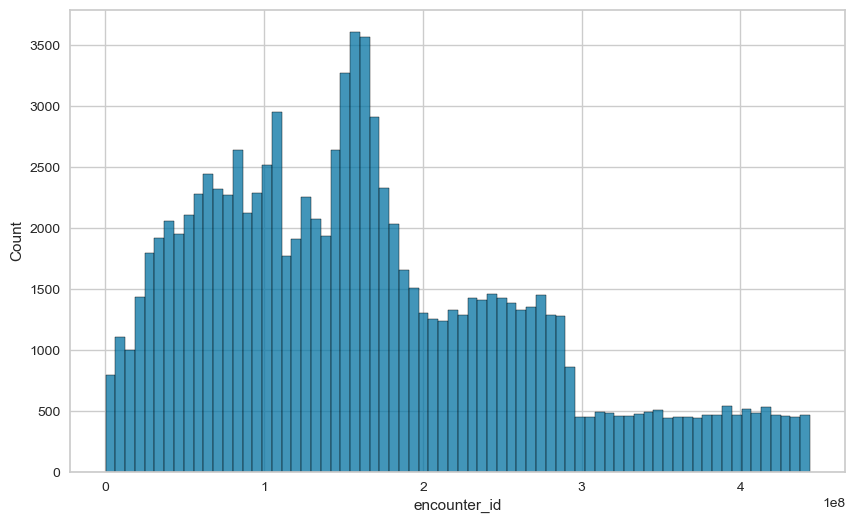

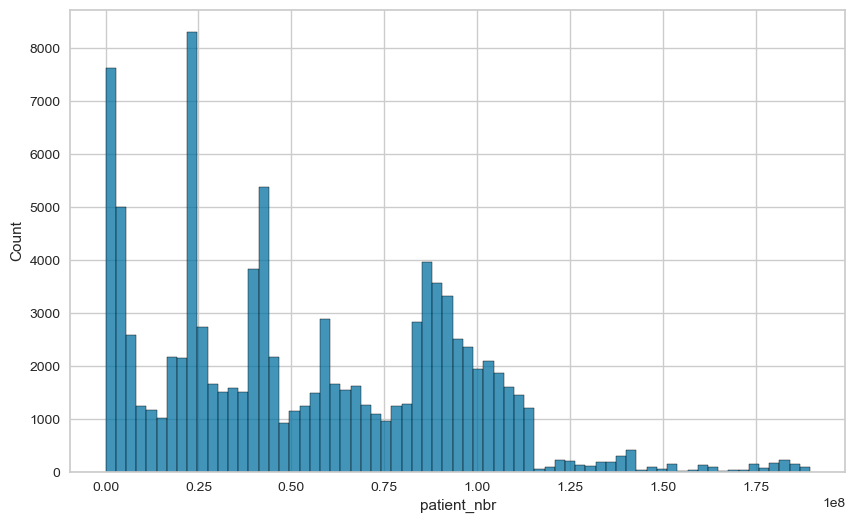

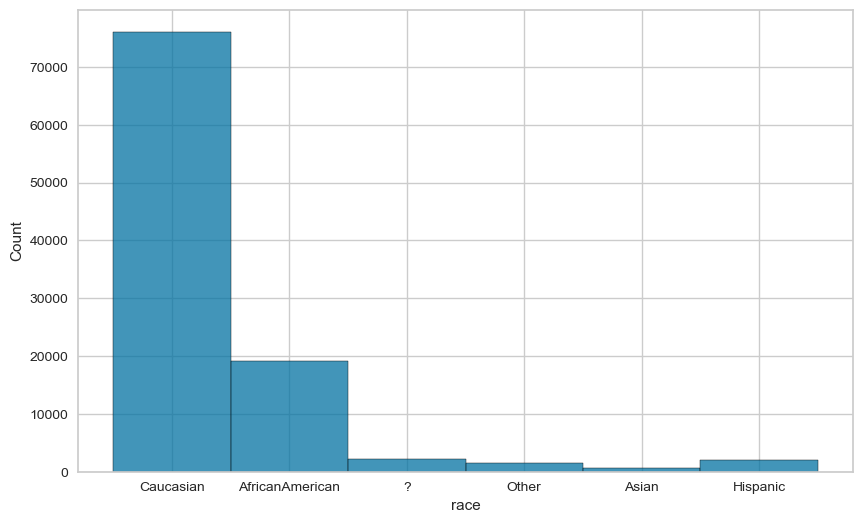

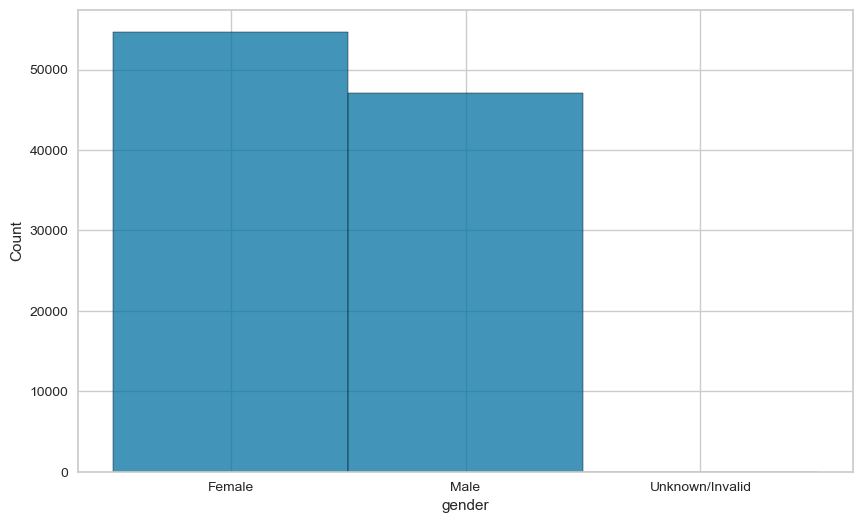

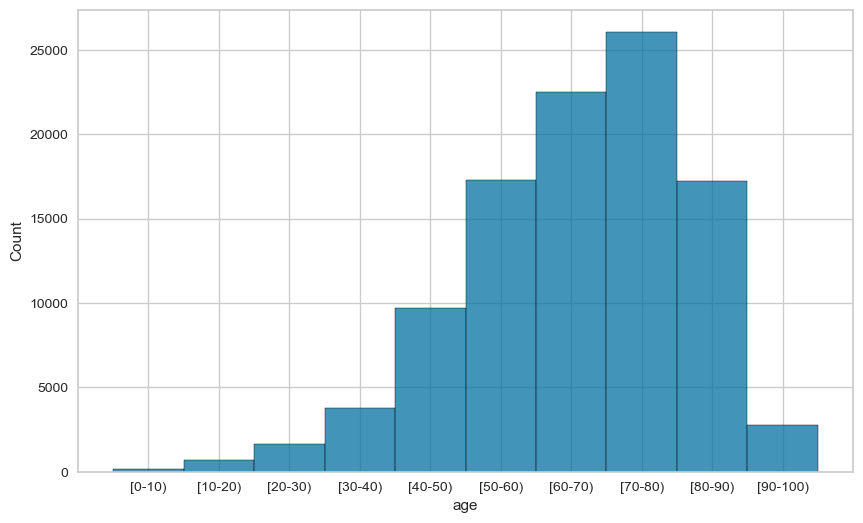

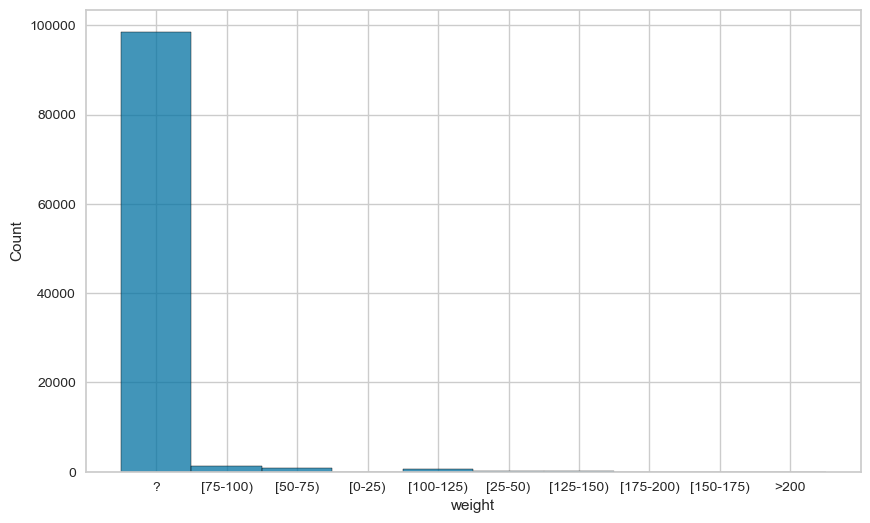

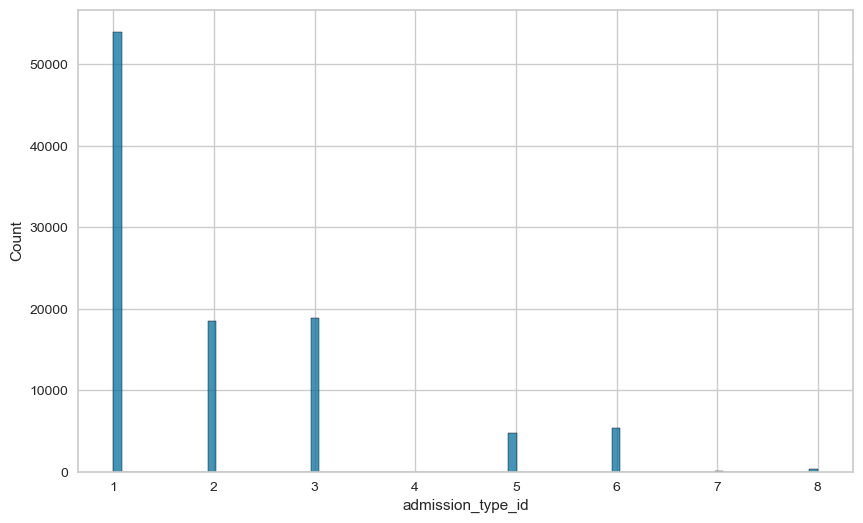

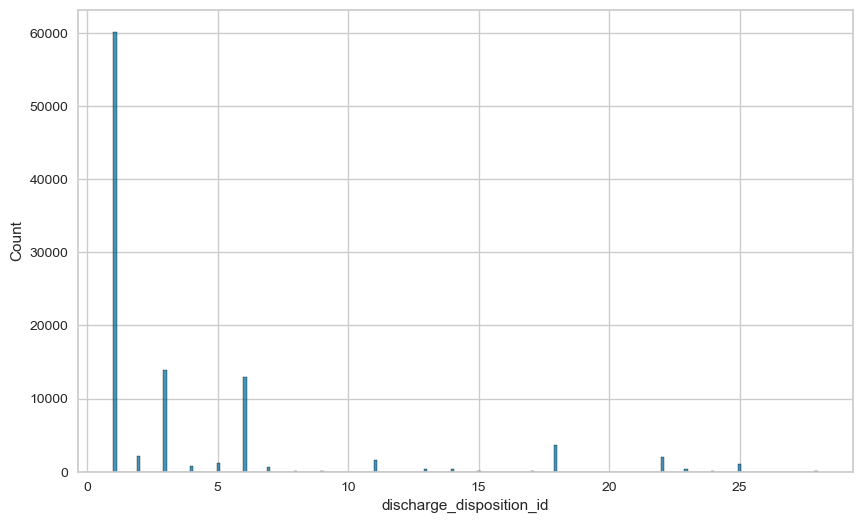

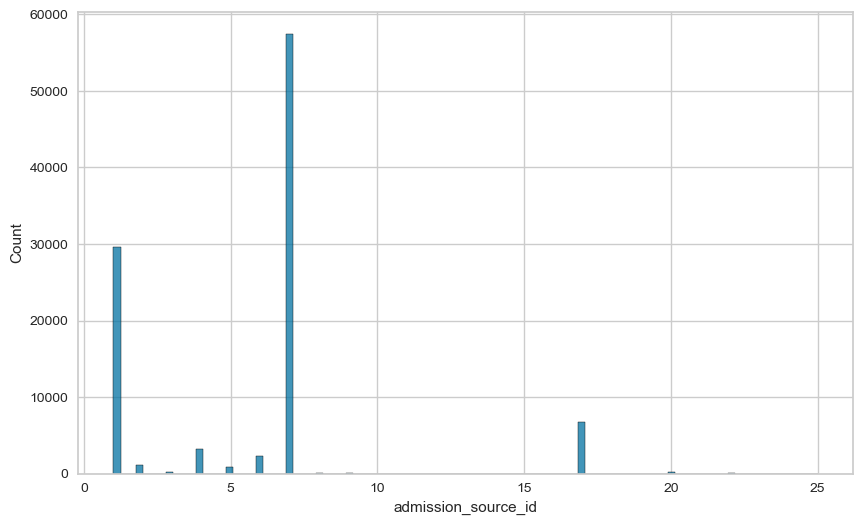

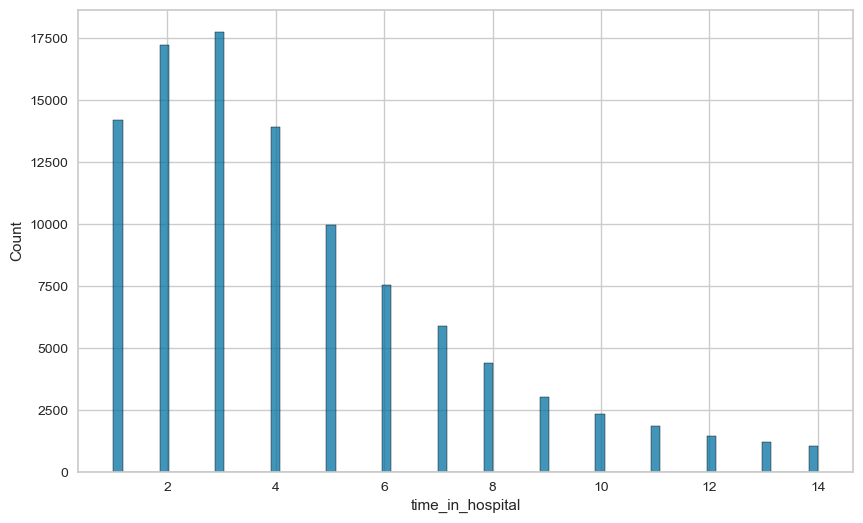

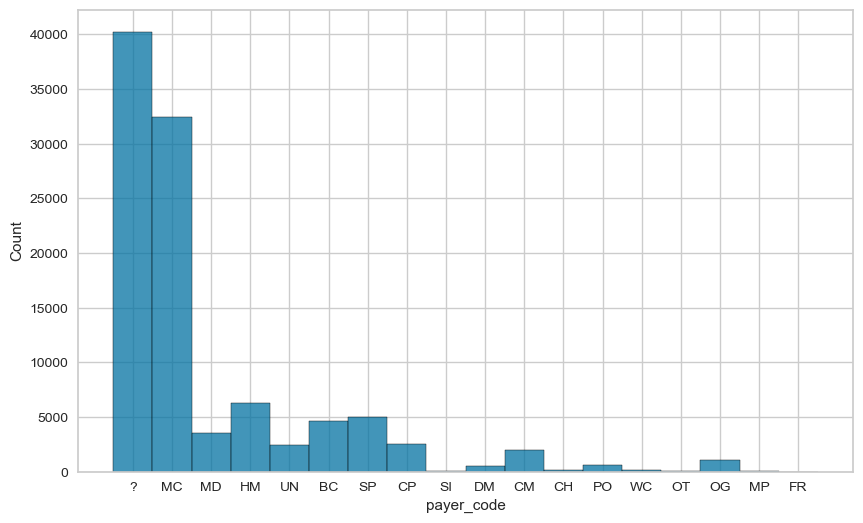

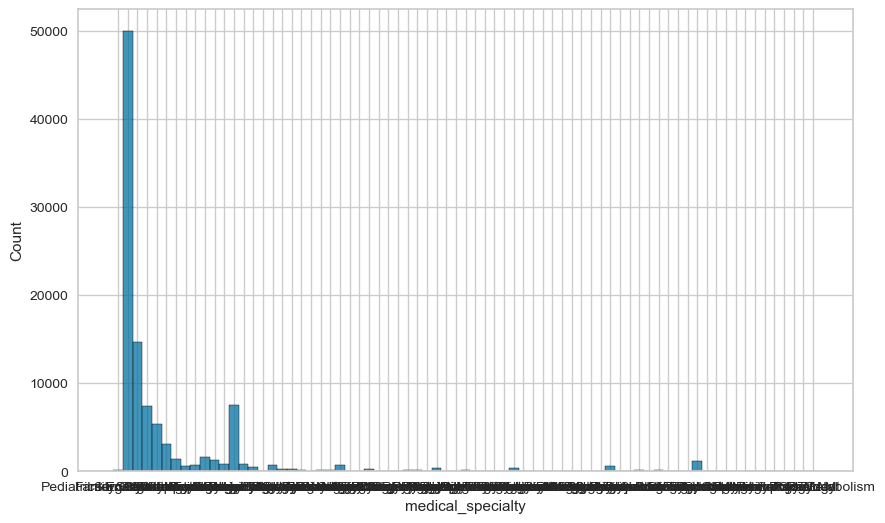

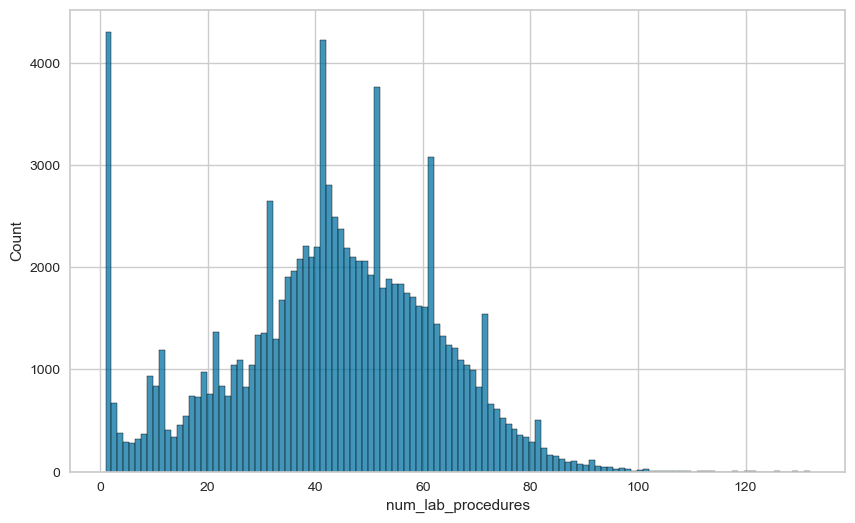

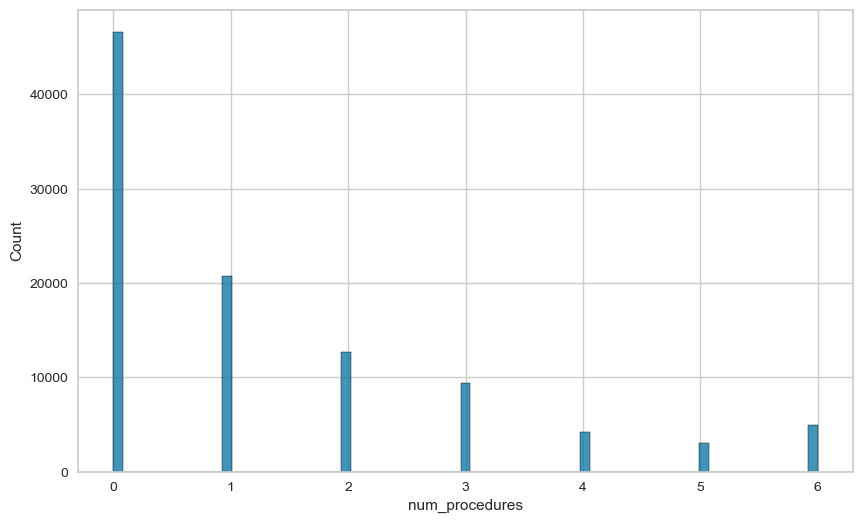

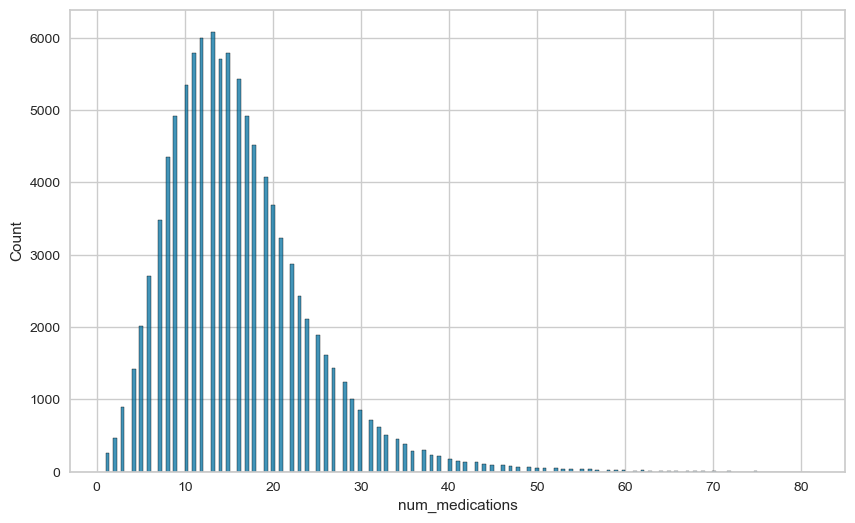

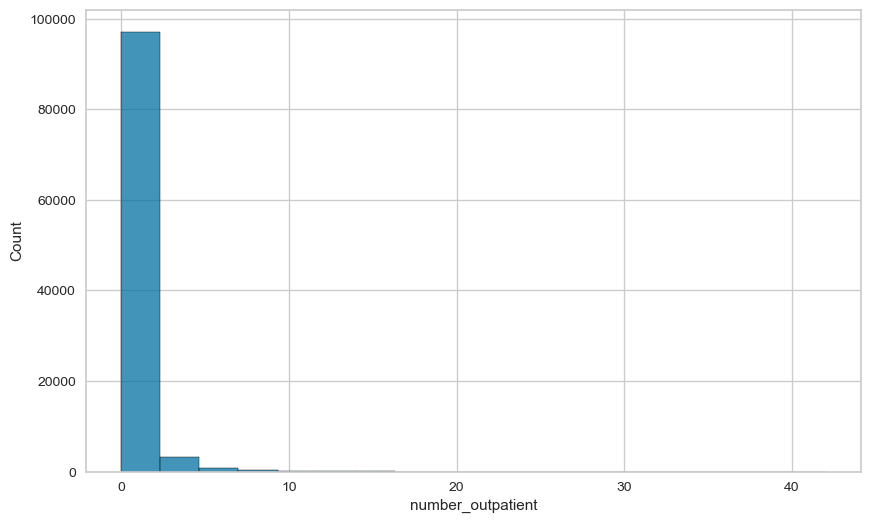

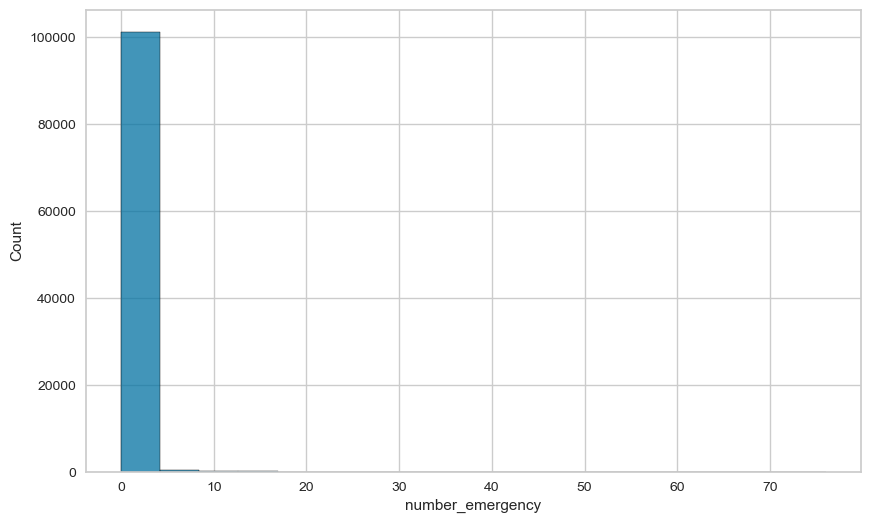

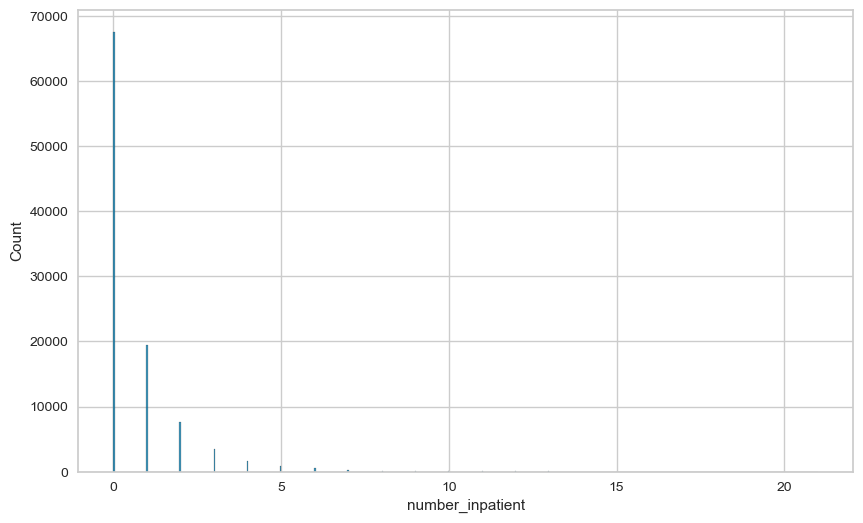

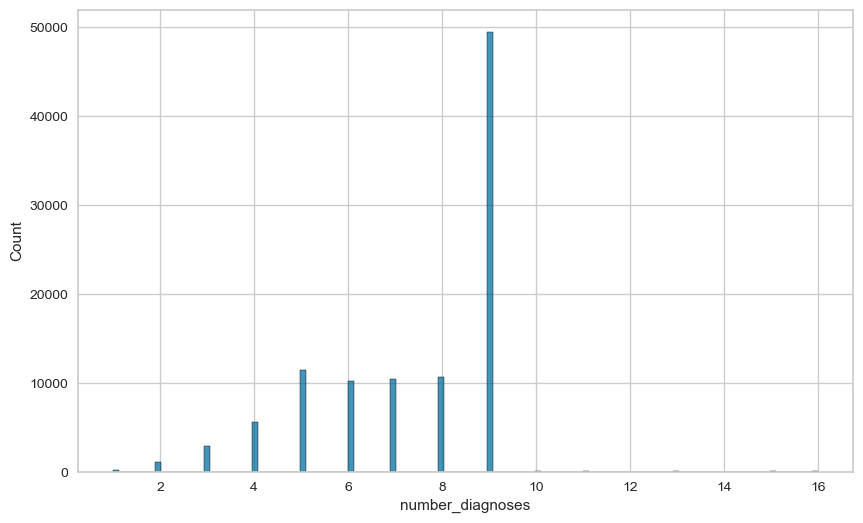

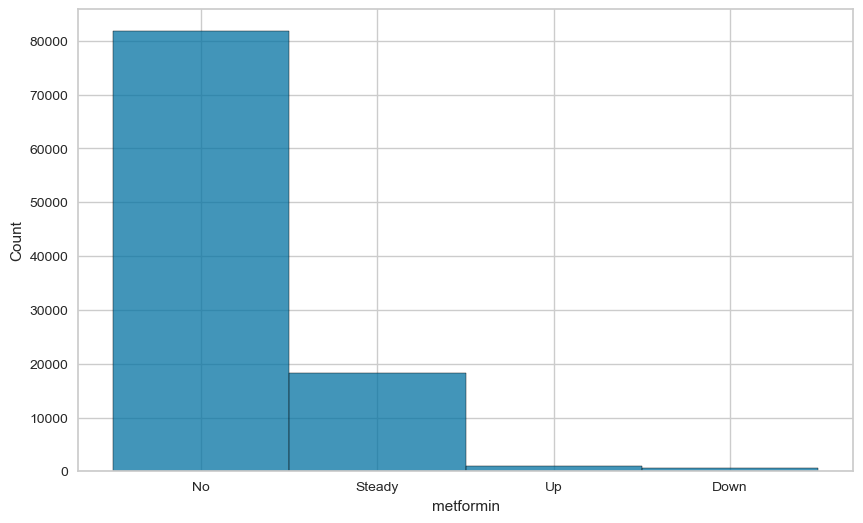

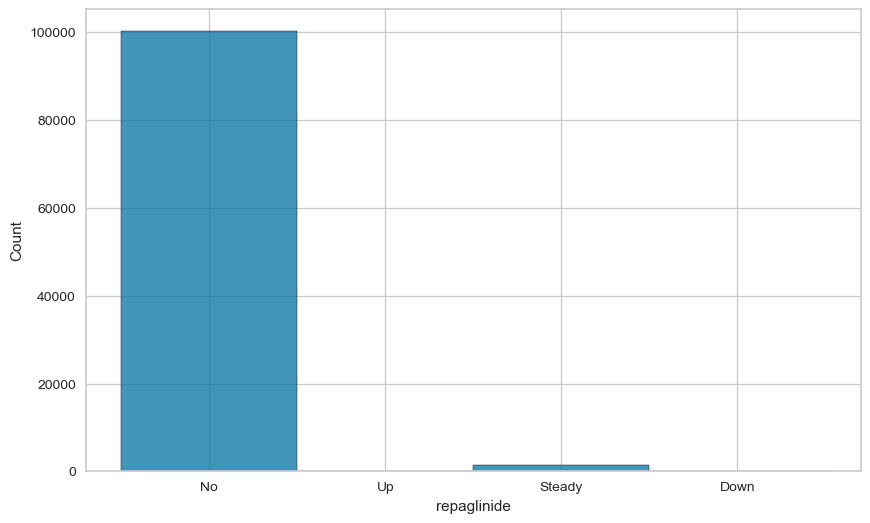

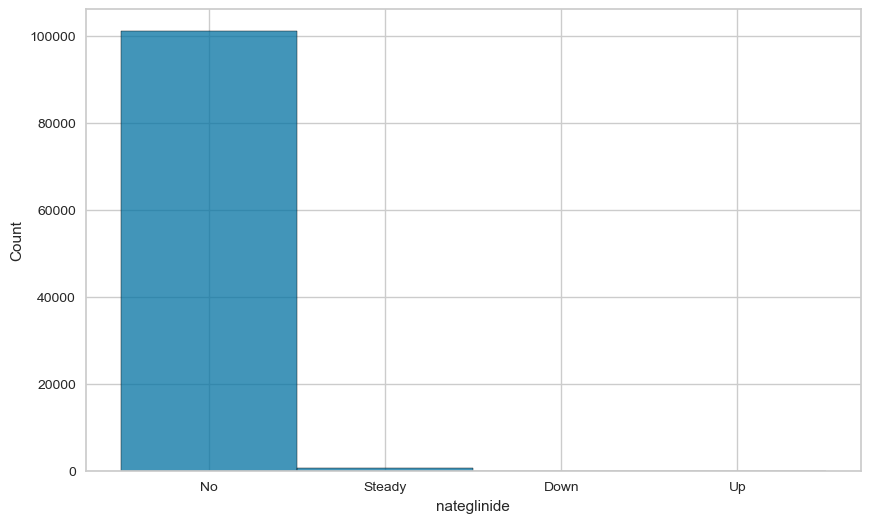

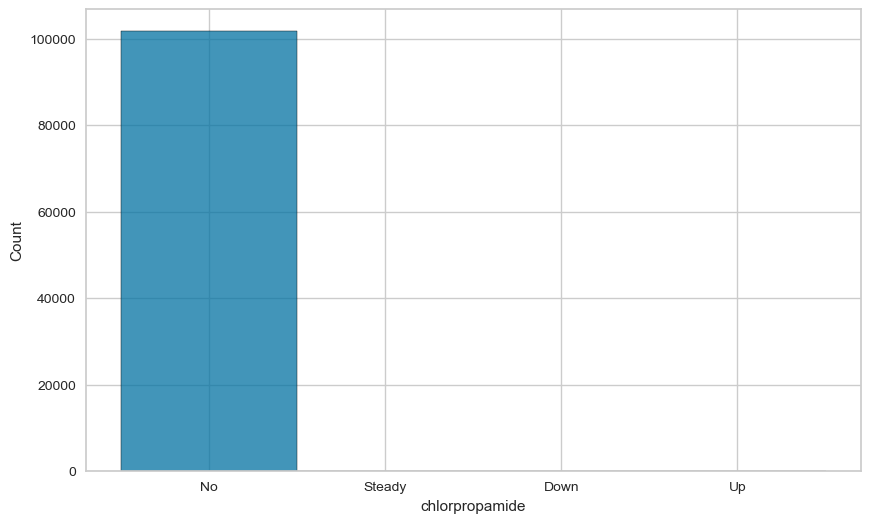

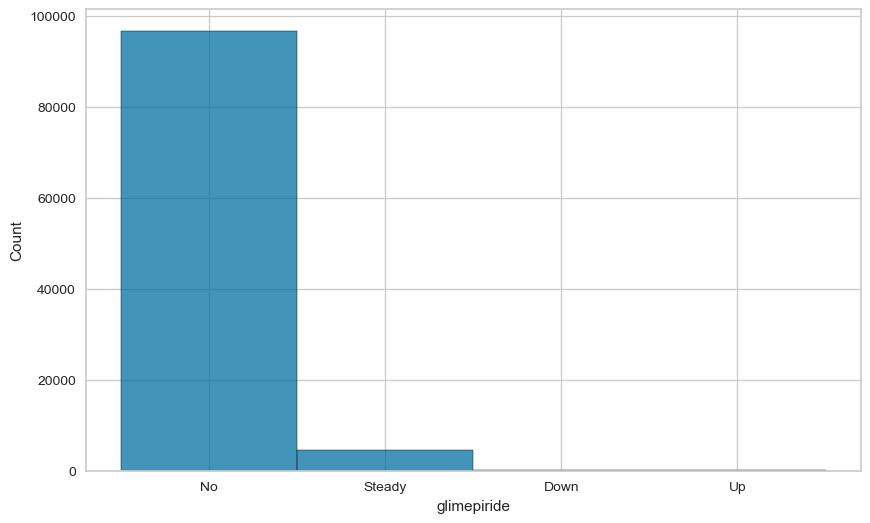

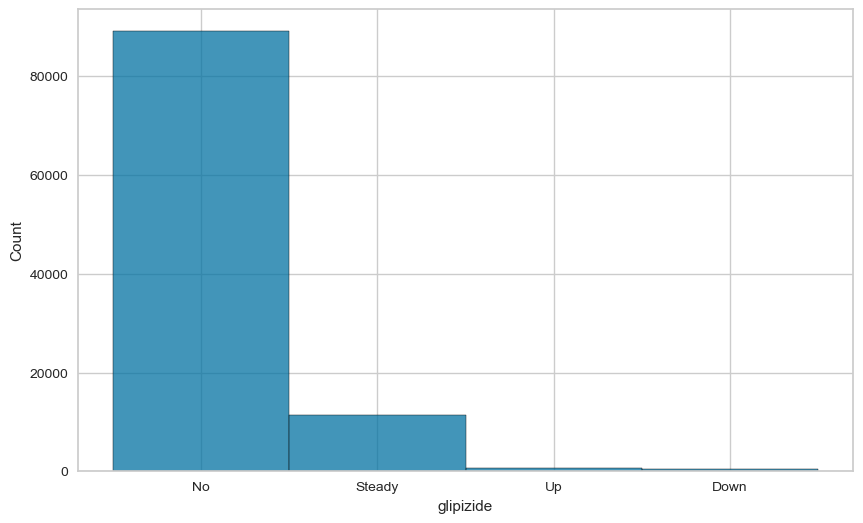

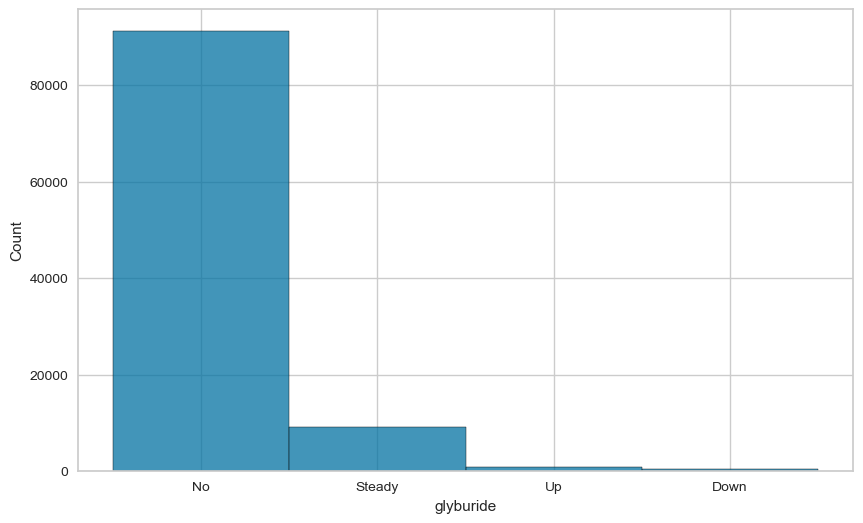

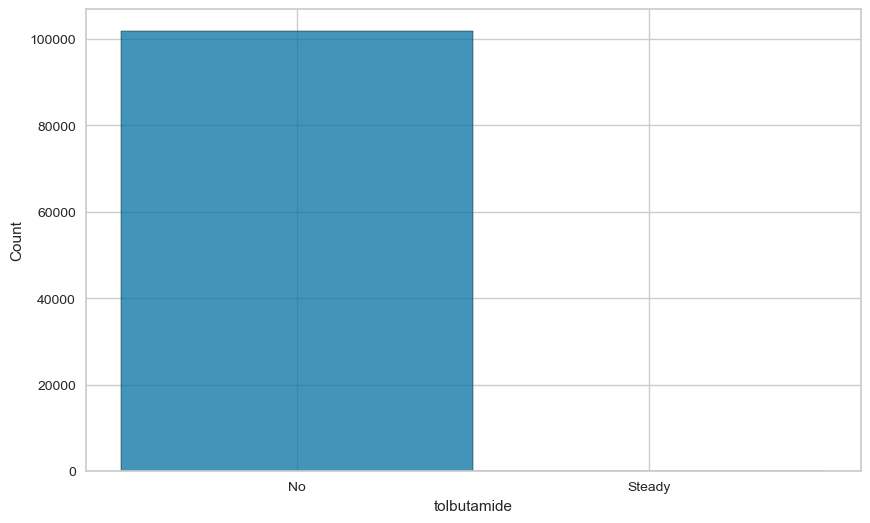

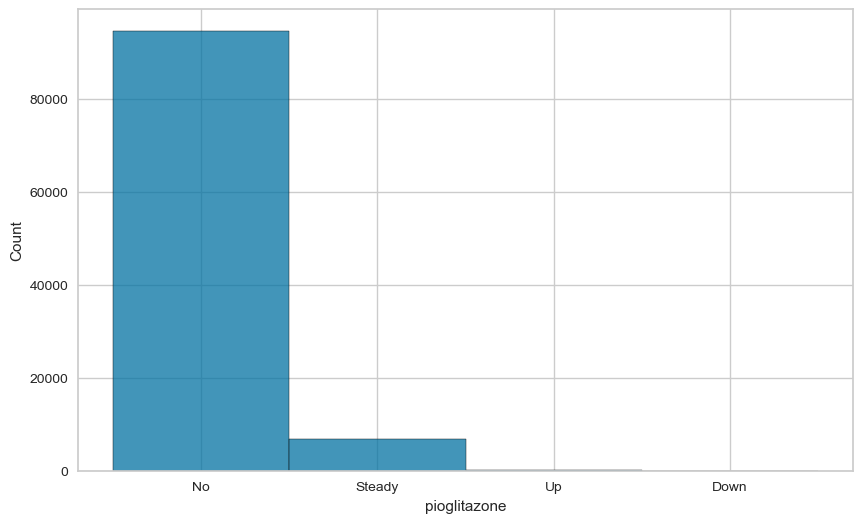

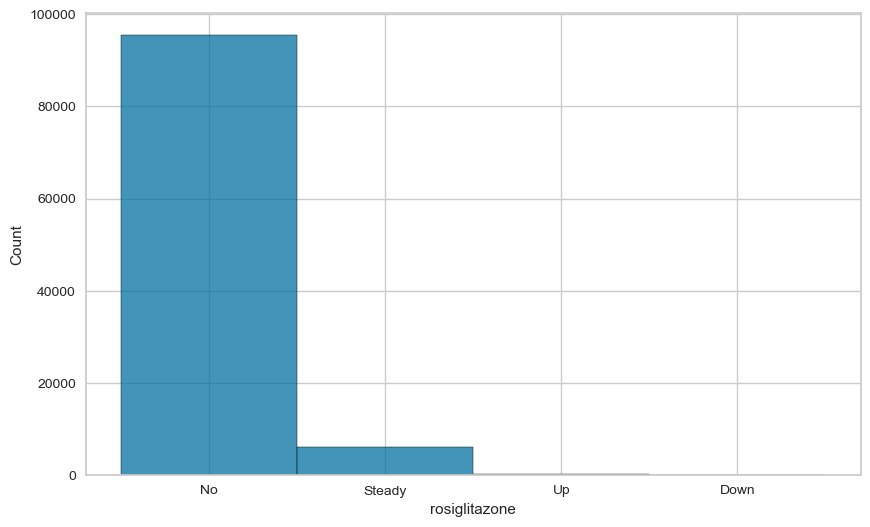

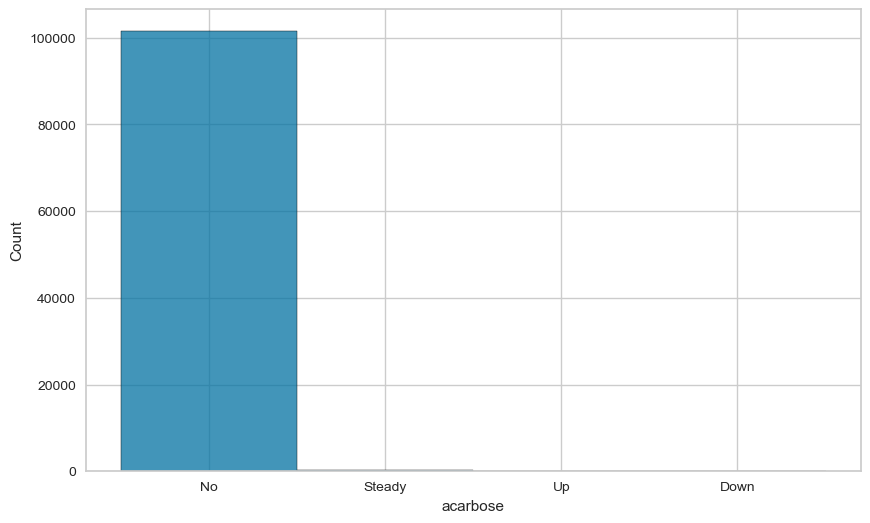

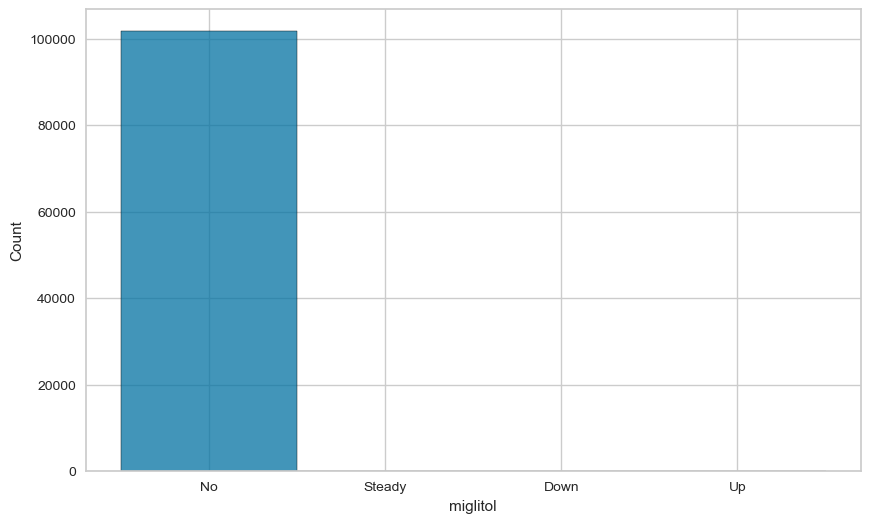

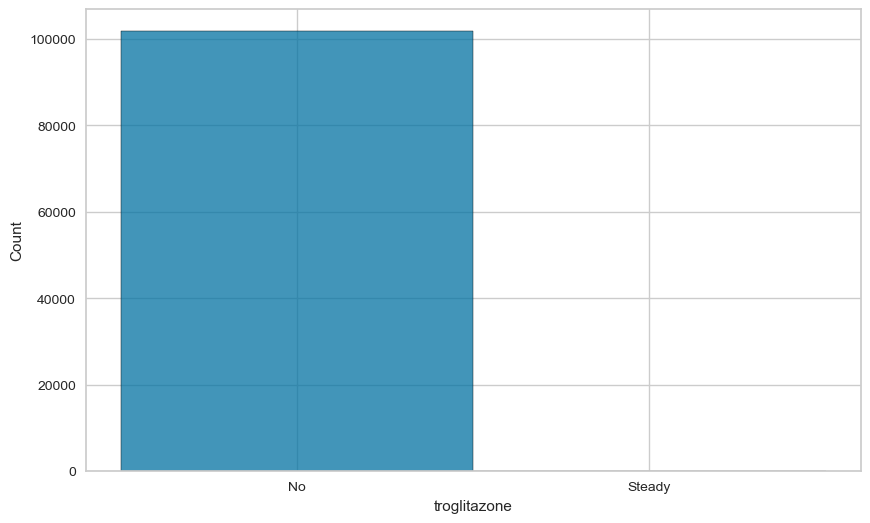

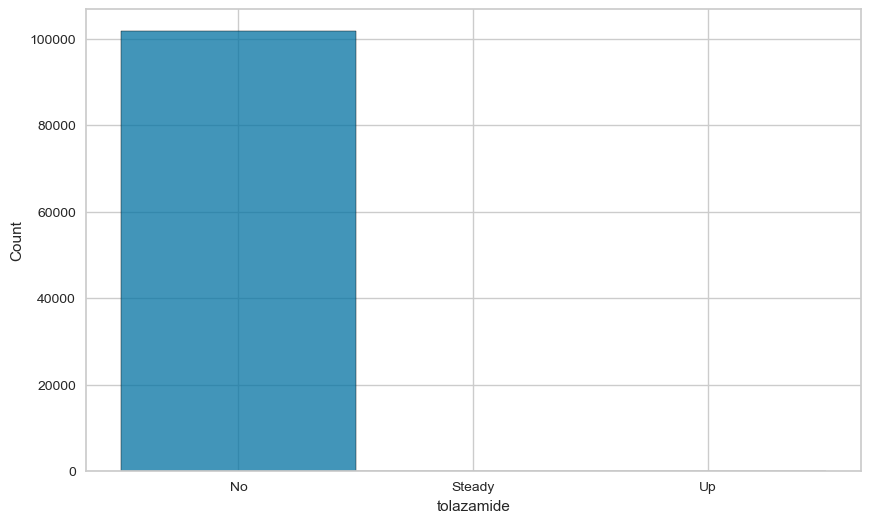

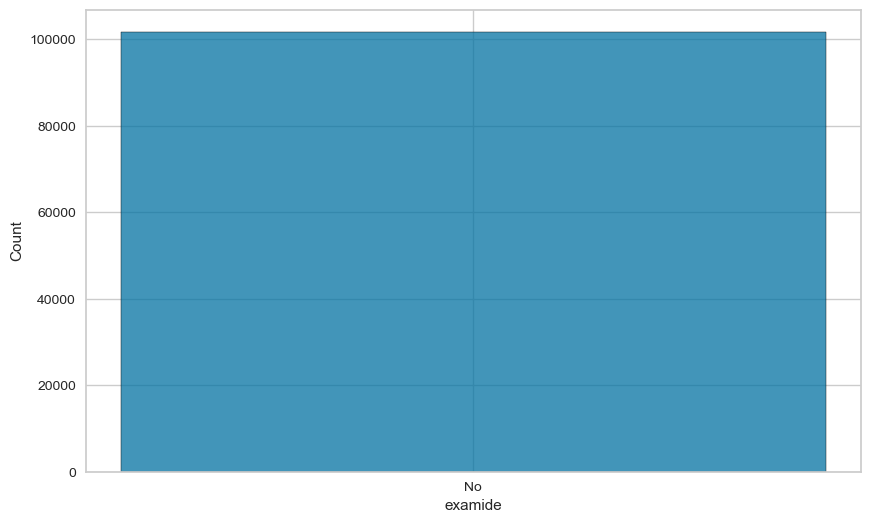

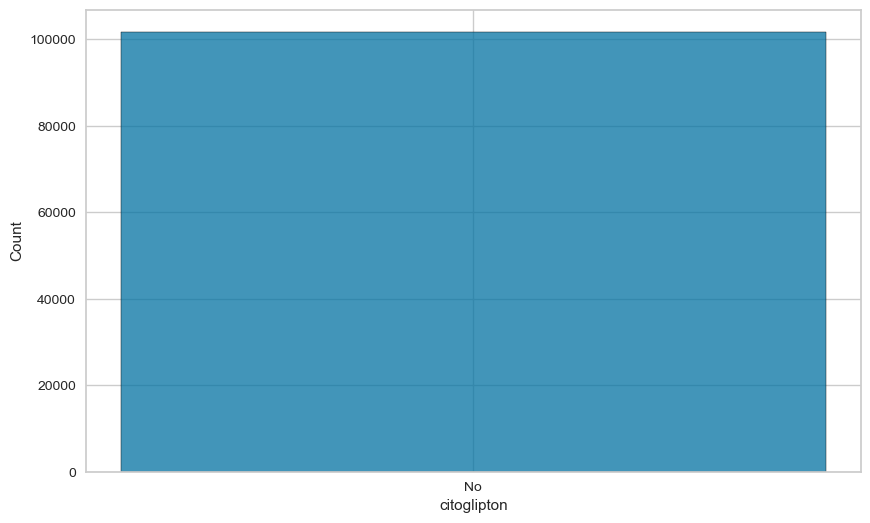

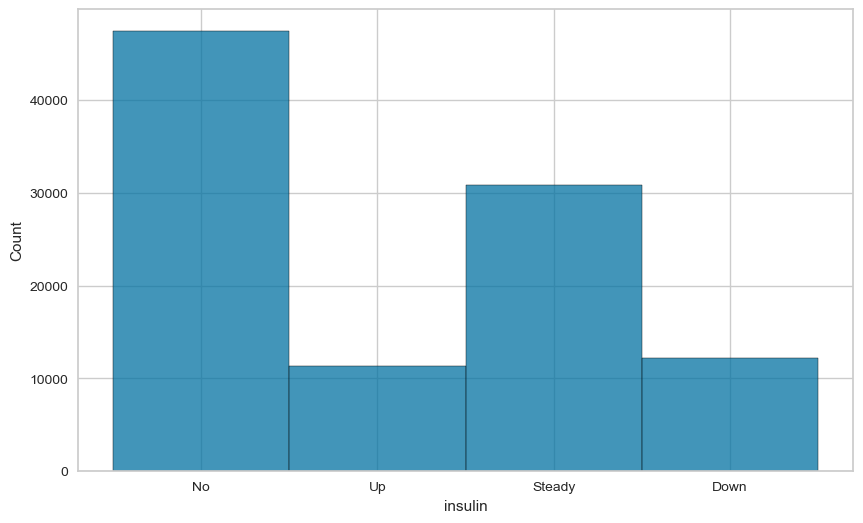

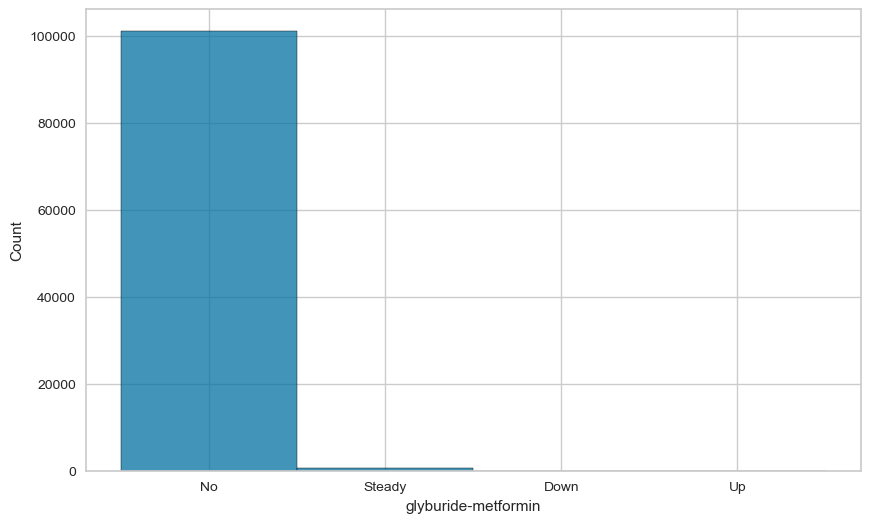

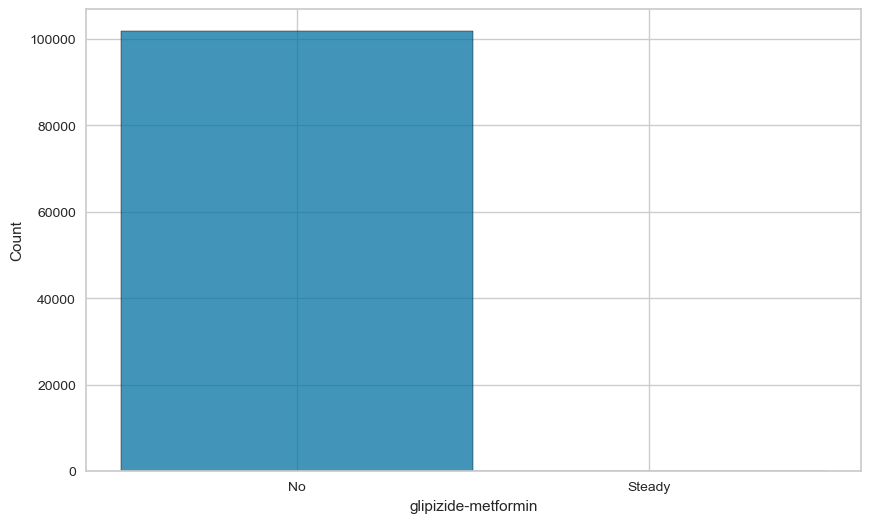

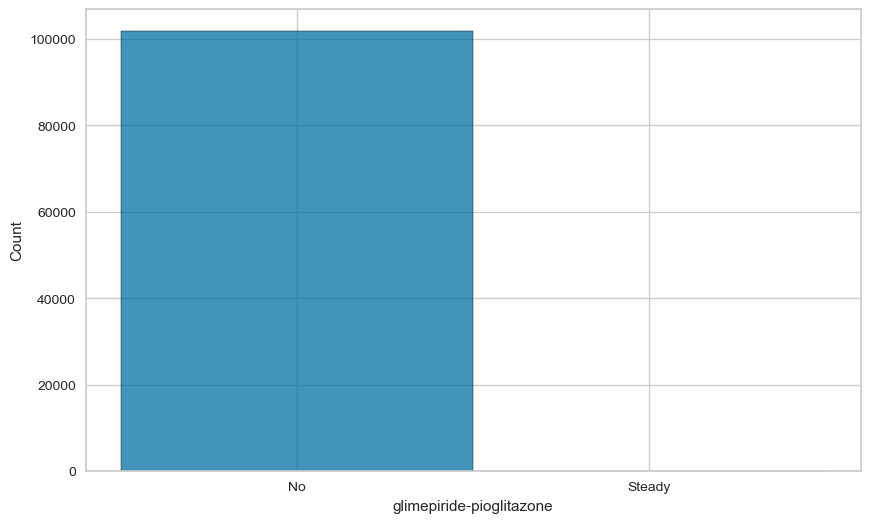

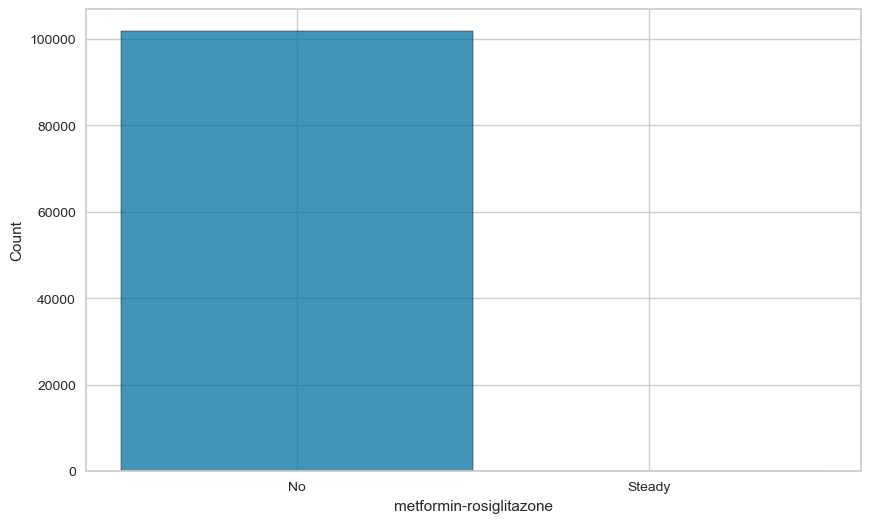

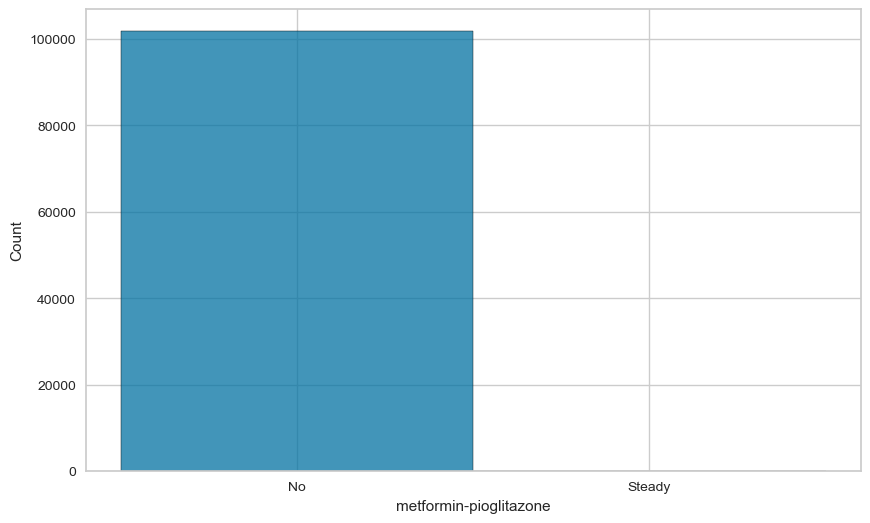

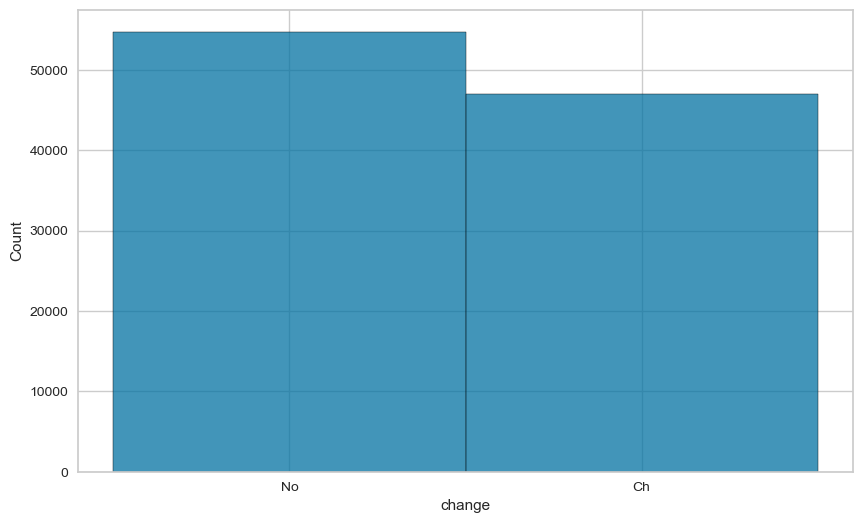

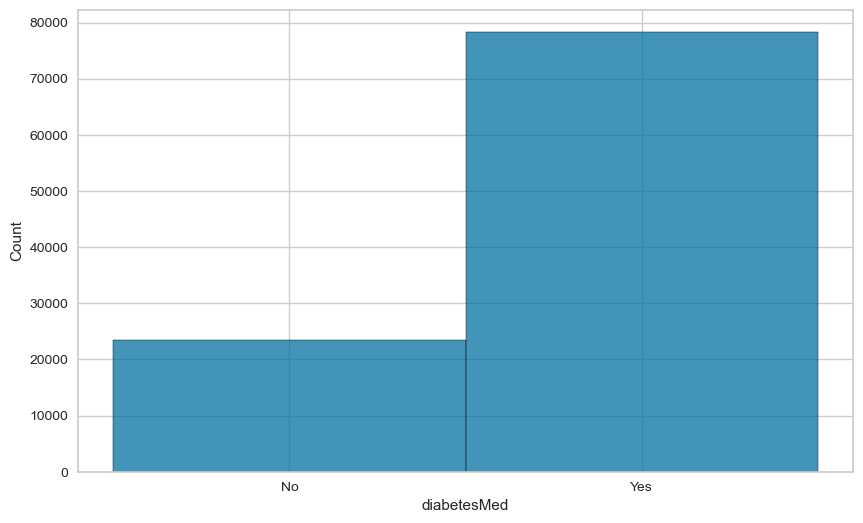

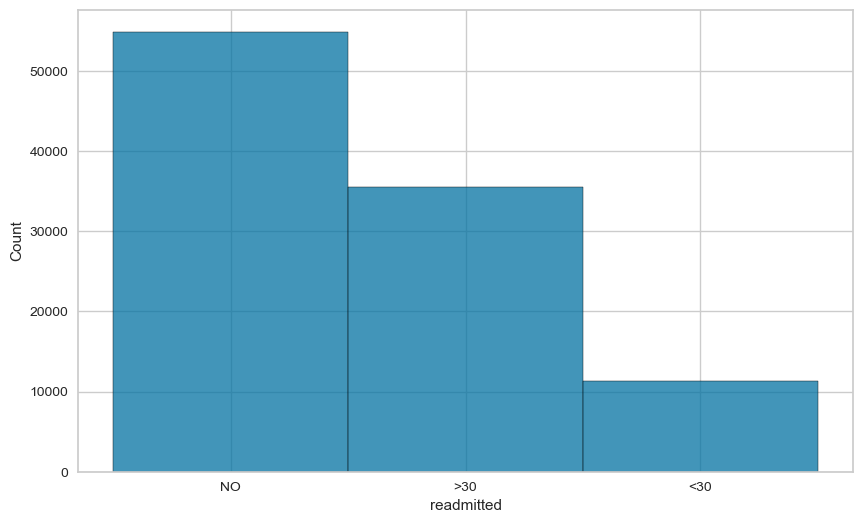

In [26]:
for col in df.columns:
    
    plt.figure(figsize=(10,6))
    sns.histplot(df[col])
    plt.show()

##### By going through the distribution above, I decided to remove few features or un-necessary rows




In [28]:
# These id features are irrelevant to 'readmitted' feature and they are not necessary to keep

df = df.drop(['encounter_id','patient_nbr', 'admission_type_id','discharge_disposition_id','admission_source_id'], axis=1)

# based on the distributions above I decided to remove these features 
df = df.drop(['payer_code', 'number_emergency', 'repaglinide', 'nateglinide', 'miglitol', 'chlorpropamide', 'acarbose', 'rosiglitazone',  'pioglitazone', 'glipizide', 'tolbutamide', 'glyburide', 'glimepiride', 'examide', 'citoglipton', 'glipizide-metformin', 'tolazamide', 'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone','troglitazone'], axis=1)


In [29]:
df.drop(df[df['gender'] == 'Unknown/Invalid'].index, inplace=True)

In [30]:
df.drop(df[df['race'] == '?'].index, inplace=True)

In [33]:
df.drop('weight', axis=1, inplace=True)

In [37]:
# I pass this to array to be able to check the column names quickly
np.array(df.columns)

array(['race', 'gender', 'age', 'time_in_hospital', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_inpatient', 'number_diagnoses',
       'metformin', 'insulin', 'glyburide-metformin', 'change',
       'diabetesMed', 'readmitted'], dtype=object)

In [39]:
# I would drop this feature as it is not relevant to readmitted column and it has high cardinality
print(df['medical_specialty'].unique())
df = df.drop(['medical_specialty'], axis=1)


['Pediatrics-Endocrinology' '?' 'InternalMedicine'
 'Family/GeneralPractice' 'Cardiology' 'Surgery-General' 'Orthopedics'
 'Gastroenterology' 'Surgery-Cardiovascular/Thoracic' 'Nephrology'
 'Orthopedics-Reconstructive' 'Psychiatry' 'Emergency/Trauma'
 'Pulmonology' 'Surgery-Neuro' 'Obsterics&Gynecology-GynecologicOnco'
 'ObstetricsandGynecology' 'Pediatrics' 'Otolaryngology'
 'Surgery-Colon&Rectal' 'Pediatrics-CriticalCare' 'Endocrinology'
 'Hematology/Oncology' 'Urology' 'Psychiatry-Child/Adolescent'
 'Pediatrics-Pulmonology' 'Neurology' 'Anesthesiology-Pediatric'
 'Radiology' 'Pediatrics-Hematology-Oncology' 'Psychology' 'Podiatry'
 'Gynecology' 'Oncology' 'Pediatrics-Neurology' 'Surgery-Plastic'
 'Surgery-Thoracic' 'Surgery-PlasticwithinHeadandNeck' 'Ophthalmology'
 'Surgery-Pediatric' 'Pediatrics-EmergencyMedicine'
 'PhysicalMedicineandRehabilitation' 'InfectiousDiseases' 'Anesthesiology'
 'Rheumatology' 'AllergyandImmunology' 'Surgery-Maxillofacial'
 'Pediatrics-InfectiousDiseases

In [41]:
# Drop missing or invalid values
df = df.replace('?', np.nan).dropna()

In [43]:
# OneHoTEncoder

#Select categorical columns to apply encoder
categorical_col = df.select_dtypes(include=['object'])

# Encoder instance with oneHotEncoder
one_h_e = OneHotEncoder(sparse_output=False)

# Fit the encoder to categorical features
df_encode = one_h_e.fit_transform(df[categorical_col.columns])

# Convert to data frame to have accessible format
df_encode = pd.DataFrame(df_encode,  columns = one_h_e.get_feature_names_out())

# See how big is the encoded data frame
df_encode.shape


(99492, 36)

In [45]:
# Join the categorical and numerical features and be prepared to fit the classification Model

# Select numerical columns (excluding target variable 'readmitted')
numerical_cols = [col for col in df.select_dtypes(include=['float64', 'int64', 'number']).columns if col != 'readmitted']

# Concatenate numerical and encoded categorical features
df_encoded_all = pd.concat([df_encode, df[numerical_cols].reset_index(drop=True)], axis=1)

# df_encoded_all.head(3)

In [47]:
# To get the idea of features' corrolations
df[numerical_cols].corr()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_inpatient,number_diagnoses
time_in_hospital,1.000000,0.317656,0.193264,0.466394,-0.009546,0.073403,0.220671
num_lab_procedures,0.317656,1.000000,0.058451,0.267013,-0.008562,0.039730,0.151565
num_procedures,0.193264,0.058451,1.000000,0.385532,-0.024932,-0.065834,0.072380
num_medications,0.466394,0.267013,0.385532,1.000000,0.044530,0.064997,0.258623
number_outpatient,-0.009546,-0.008562,-0.024932,0.044530,1.000000,0.106234,0.092455
number_inpatient,0.073403,0.039730,-0.065834,0.064997,0.106234,1.000000,0.103245
number_diagnoses,0.220671,0.151565,0.072380,0.258623,0.092455,0.103245,1.000000


In [49]:
# numerical and categorical (all numeric data)
df_encoded_all.head()
print(f'size of dataset after oneHotEncoder: {df_encoded_all.shape}')

size of dataset after oneHotEncoder: (99492, 43)


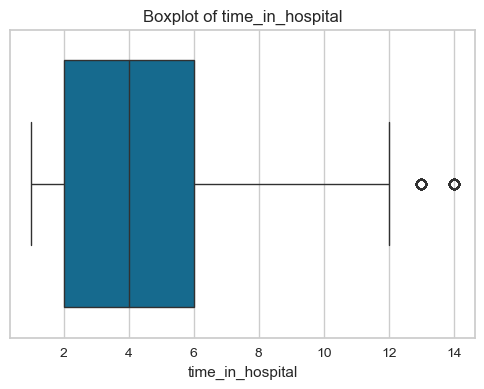

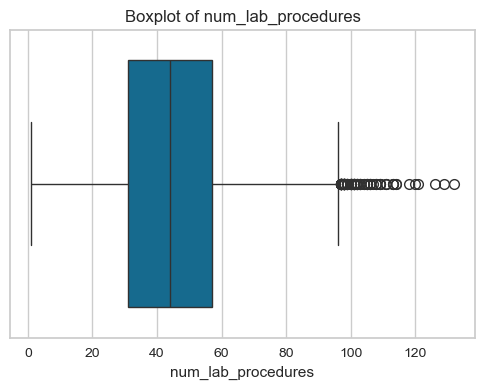

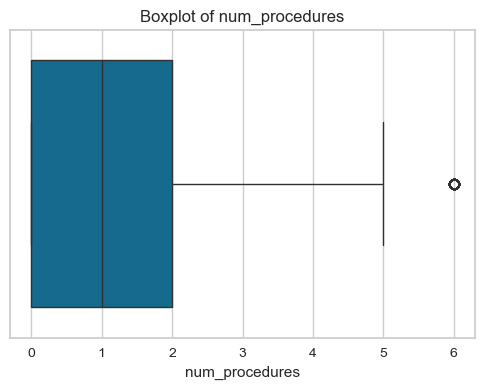

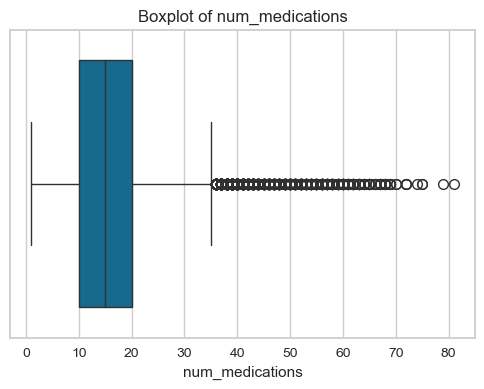

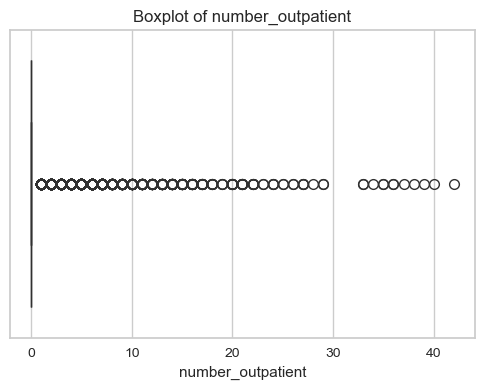

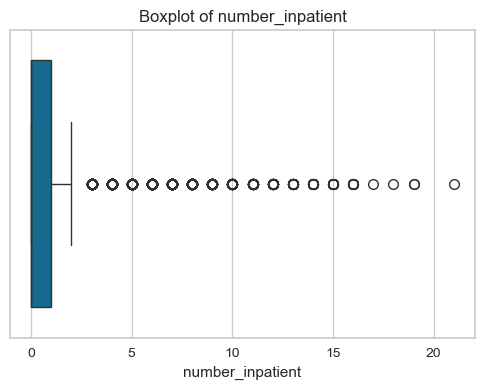

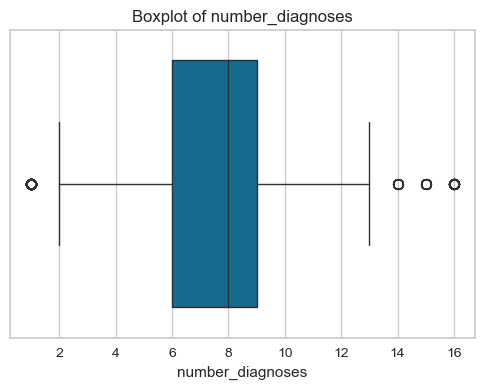

In [51]:
# I wanted to see how is the outliers in each feature
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x=col)
    plt.title(f"Boxplot of {col}")
    plt.show()

<Figure size 1500x900 with 0 Axes>

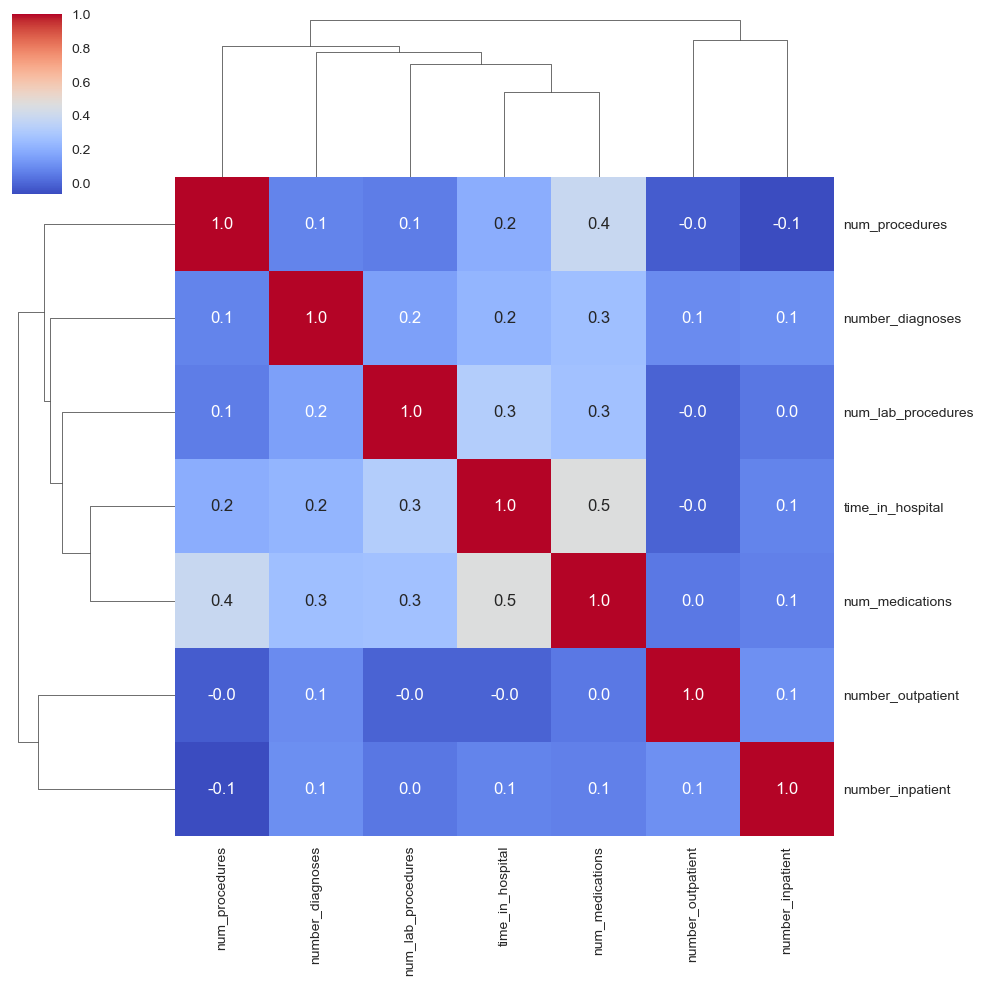

In [52]:
# Clustering map between the numerical columns
plt.figure(figsize=(15,9))
# numeric_categoric =[]
sns.clustermap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt= '.1f')

In the clustering map above we see higher connections/correlations between num_procedures/num_medications or time_in_hospital/num_medications, number_inpatient/number_ inpatient.


In [56]:
#Standard scaling of the data values
# Create instance of Standard Scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded_all)
X_scaled.shape

(99492, 43)

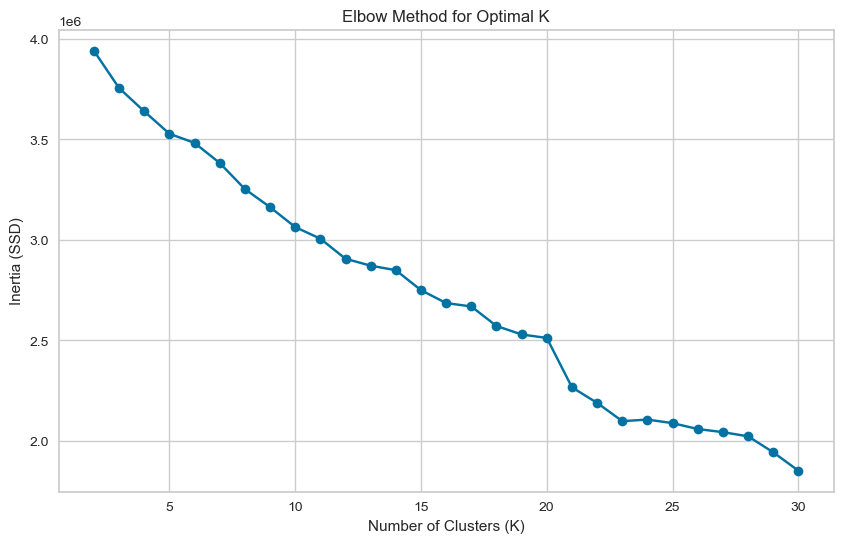

In [58]:
ssd = []  

for k in range(2, 31):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=55)
    kmeans.fit(X_scaled)
    ssd.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(2, 31), ssd, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (SSD)')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.savefig('ElbowMethod.png', dpi=300, bbox_inches='tight')
plt.show()


K = 10 to K = 12 looks like the best elbow point.
There’s a bend (elbow) between K = 5 and K = 8. After K = 8, the rate of SSD reduction slows down

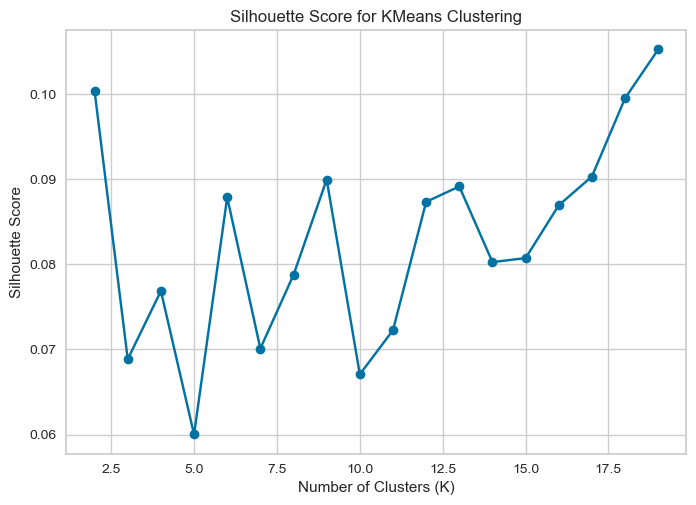

In [34]:
silhouette_scores = []

for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

plt.plot(range(2, 20), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for KMeans Clustering')
plt.savefig('KmeanSilh.png', dpi=300, bbox_inches='tight')
plt.show()

Highest silhouette scores are at K = 3 and K = 6.

Score drops significantly at K ≥ 8, meaning less clustering works for K higher than 8

K = 6 is a strong choice because:

- It is in the elbow area

- One of the highest silhouette scores

- A manageable number of clusters for visualization



## Kmean Cluster with K=6

In [60]:
# Instance of k_mean model
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42)
kmeans.fit(X_scaled)
df['Cluster']= kmeans.labels_

In [62]:
# To have a summary of the percentage of the 'readmitted' date belong to each cluster

summary = []

for cluster_id in range(6):
    cluster_data = df[df["Cluster"] == cluster_id]
    cluster_size = len(cluster_data)
    readmit_30_count = (cluster_data["readmitted"] == "<30").sum()
    proportion_30 = readmit_30_count / cluster_size if cluster_size > 0 else 0
    
    summary.append({
        "Cluster": cluster_id,
        "Size": cluster_size,
        "<30 Readmits": readmit_30_count,
        "Proportion <30": f"{proportion_30:.2%}"
    })

summary_df = pd.DataFrame(summary)


In [64]:
# Print the summary
print(summary_df.sort_values("Proportion <30", ascending=False).to_string(index=False))


 Cluster  Size  <30 Readmits Proportion <30
       0 23001          2218          9.64%
       1 18003          2527         14.04%
       5 16097          1818         11.29%
       4 22603          2544         11.26%
       3   671            72         10.73%
       2 19117          1990         10.41%


In [66]:
# Filter patients readmitted in <30 days
plot_df = df[df['readmitted'] == '<30']

# PCA to reduce to 2 components for plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for plotting
plot_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
plot_df['cluster'] = kmeans.labels_
plot_df['readmitted'] = df['readmitted'].values

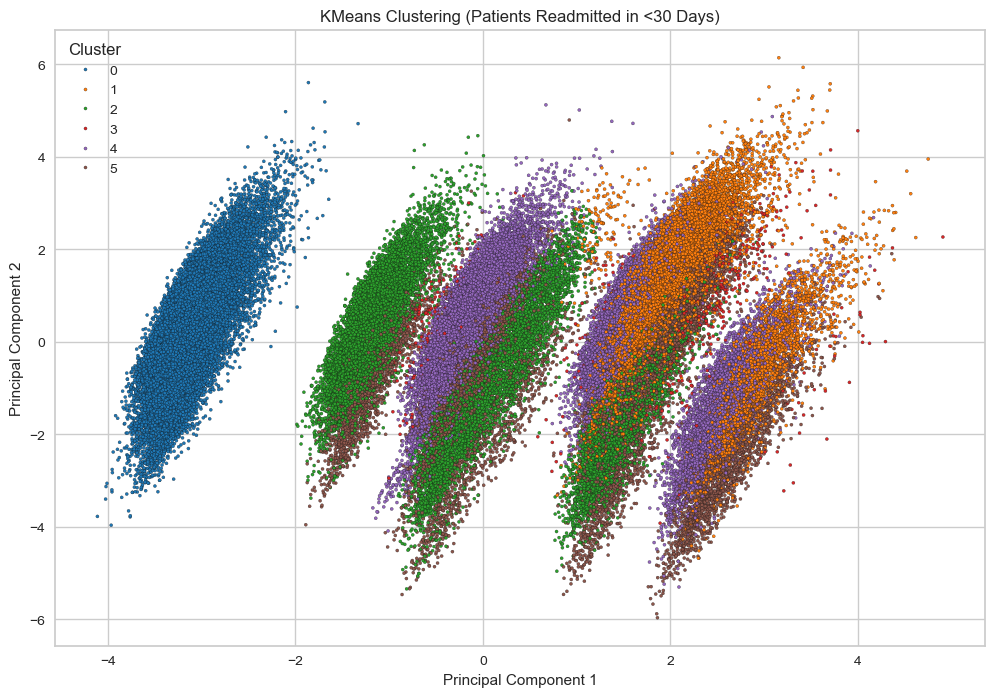

In [68]:
# Display the PCA plot of the cluster
plt.figure(figsize=(12, 8))
sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='cluster', palette='tab10', s=5, edgecolor='k')
plt.title('KMeans Clustering (Patients Readmitted in <30 Days)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.savefig('KmeansPlot.png', dpi=300, bbox_inches='tight')
plt.show()


## Agglomerative Clustering

To have another clustering for the same K=8 value.

In [77]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering

# Randomly select 20% of the data (without replacement)
sample_size = int(0.1 * X_scaled.shape[0])
random_indices = np.random.choice(X_scaled.shape[0], size=sample_size, replace=False)

# Subset the data for the selected random indices
X_sampled = X_scaled[random_indices]



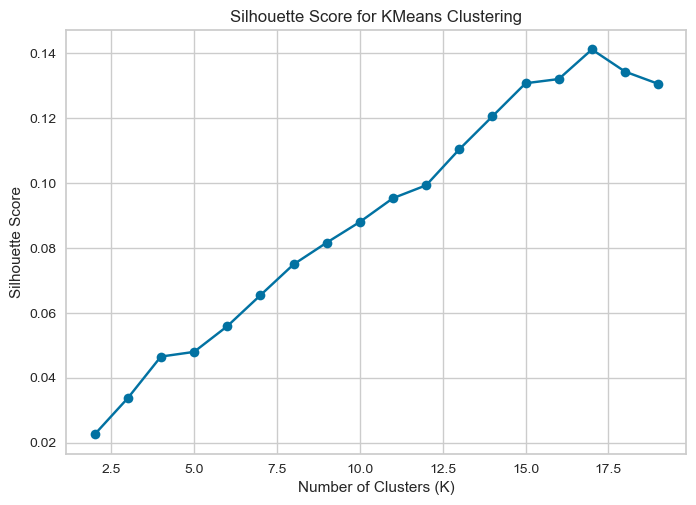

In [79]:
silhouette_scores = []

for k in range(2, 20):
    ac = AgglomerativeClustering(n_clusters= k, metric='euclidean', linkage='ward')
    ac.fit(X_sampled)

    score = silhouette_score(X_sampled, ac.labels_)
    silhouette_scores.append(score)

plt.plot(range(2, 20), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Agglomerative Clustering')
plt.savefig('AggSilh.png', dpi=300, bbox_inches='tight')
plt.show()

The highest score is at K=17 then there is a drop means that less clustering works for K higher than 17.

In [83]:
# Agglomerative clustering for K=17
ac = AgglomerativeClustering(n_clusters= 17, metric='euclidean', linkage='ward')
ac.fit(X_sampled)

AgglomerativeClustering(n_clusters=17)

In [87]:
# Get the cluster labels for the sampled data
cluster_labels = ac.labels_

# Create a copy of the original dataframe (assuming df is the original dataset)
df['cluster_ac'] = -1  # Initialize the column with a default value (-1 for unclustered)

# Assign the cluster labels to the sampled indices using .iloc for positional indexing
df.iloc[random_indices, df.columns.get_loc('cluster_ac')] = cluster_labels

# Now df['cluster_ac'] contains the clustering labels for the original data
print(df.head())  # Check the first few rows of the dataframe to verify

              race  gender      age  time_in_hospital  num_lab_procedures  \
0        Caucasian  Female   [0-10)                 1                  41   
1        Caucasian  Female  [10-20)                 3                  59   
2  AfricanAmerican  Female  [20-30)                 2                  11   
3        Caucasian    Male  [30-40)                 2                  44   
4        Caucasian    Male  [40-50)                 1                  51   

   num_procedures  num_medications  number_outpatient  number_inpatient  \
0               0                1                  0                 0   
1               0               18                  0                 0   
2               5               13                  2                 1   
3               1               16                  0                 0   
4               0                8                  0                 0   

   number_diagnoses metformin insulin glyburide-metformin change diabetesMed  \
0     

In [91]:
score = silhouette_score(X_sampled, cluster_labels)
score

0.14124178651109923

So for Agglomerative clustering with K=17 we got the highest Silouhette score = 0.1412

In [103]:
X_sampled['readmitted']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [127]:
# Filter patients readmitted in <30 days
agg_plot_df = df[df['readmitted'] == '<30']

# PCA to reduce to 2 components for plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sampled)

# Create a DataFrame for plotting
agg_plot_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
agg_plot_df['ac_cluster'] = ac.labels_
agg_plot_df['ac_cluster']

0       10
1        3
2        3
3       10
4       10
        ..
9944     6
9945     0
9946    13
9947     2
9948     0
Name: ac_cluster, Length: 9949, dtype: int64

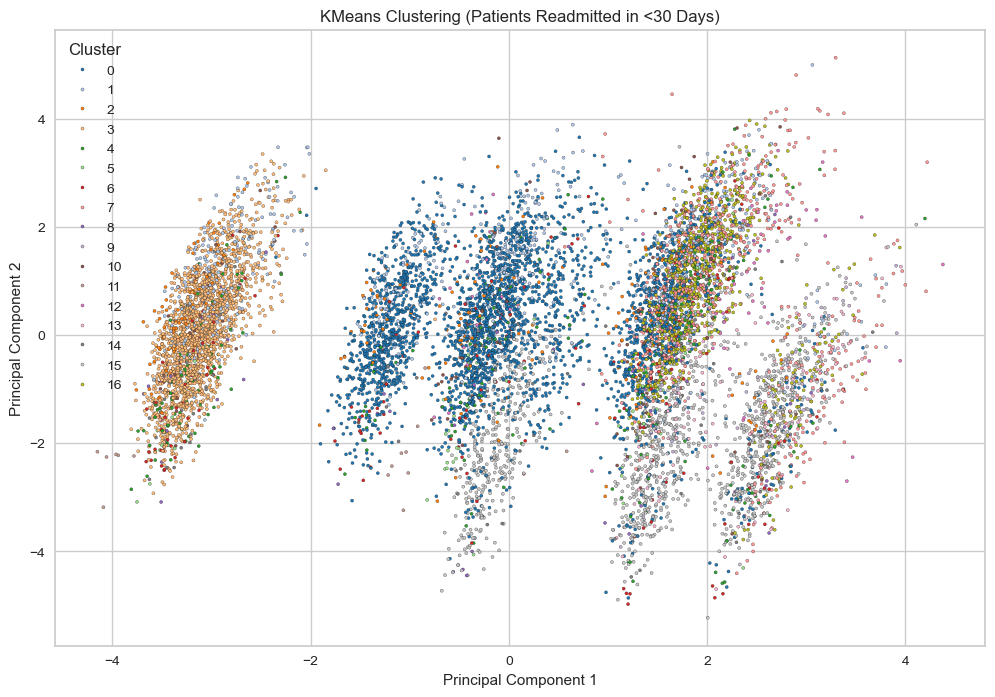

In [129]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=agg_plot_df, x='PC1', y='PC2', hue='ac_cluster', palette='tab20', s=5, edgecolor='k')
plt.title('KMeans Clustering (Patients Readmitted in <30 Days)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


### Summary of K mean Clustering Results with K= 16

The clustering analysis produced the following clusters:
| Cluster | Size | <30 Day Readmissions | Readmission Rate |
|---------|------|----------------------|------------------|
| 0       | 593  | 50                   | 8.43%            |
| 1       | 440  | 55                   | 12.50%           |
| 2       | 111  | 31                   | 27.93%           |
| 3       | 3    | 1                    | 33.33%           |
| 4       | 210  | 26                   | 12.38%           |
| 5       | 214  | 21                   | 9.81%            |
| 6       | 105  | 11                   | 10.48%           |
| 7       | 2    | 1                    | 50.00%           |
| 8       | 146  | 14                   | 9.59%            |
| 9       | 302  | 11                   | 3.64%            |
| 10      | 1    | 0                    | 0.00%            |
| 11      | 14   | 1                    | 7.14%            |
| 12      | 29   | 2                    | 6.90%            |
| 13      | 390  | 54                   | 13.85%           |


## Patient Cluster Characteristics

Based on the clustering results, here are some high-level features on the patient characteristics in each cluster:

- **Cluster 0:**  
  - **Demographics:** Mostly Caucasian with a mix of genders 
  - **Age & Weight:** Patients aged between ~50–80, commonly with weight in the [75–100) range  
  - **Hospital Stay:** Moderate length of stay (3–6 days)

- **Cluster 1:**  
  - **Demographics:** Mostly Caucasian with some patients in their 20s  
  - **Hospital Stay:** Generally around 1–12 days stay

- **Cluster 2 & 3:**  
  - **Demographics:** Older patients with higher readmission rates (up to 27–33%).  
  - **Clinical Notes:** These clusters may require closer follow-up given the increased risk of readmission.

- **Cluster 4:**  
  - **Demographics:** Older population with varied weight ranges and moderate hospital stays.  
  - **Observations:** Shows a balanced mix of lab and procedural counts.

- **Clusters 5–15:**  
  - **Variations:** These clusters differentiate further based on subtle demographic and clinical nuances (e.g., length of stay, outpatient visits, and medication counts) with readmission rates ranging from as low as 0% (Cluster 10) to 50% (Cluster 7).  
  - **Note:** Some clusters are very small (e.g., Cluster 3, Cluster 7) and might represent outlier groups.